In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Recommendation System
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

C:\Users\srira\AppData\Local\Temp\ipykernel_14420\752163494.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
import os
for dirname, _, filenames in os.walk('input.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
data_movie = pd.read_csv("movie.csv")
data_rating = pd.read_csv("rating.csv")

In [4]:
movie = data_movie.loc[:, ["movieId", "title"]]
rating = data_rating.loc[:, ["userId", "movieId", "rating"]]
data = pd.merge(movie, rating)

In [5]:
data = data.iloc[:1000000, :]

In [6]:
user_movie_table = data.pivot_table(index=["userId"], columns=["title"], values="rating").fillna(0)
print("\nUser-Movie Pivot Table Sample:")
print(user_movie_table.head(10))


User-Movie Pivot Table Sample:
title   Ace Ventura: When Nature Calls (1995)  Across the Sea of Time (1995)  \
userId                                                                         
1                                         0.0                            0.0   
2                                         0.0                            0.0   
3                                         0.0                            0.0   
4                                         3.0                            0.0   
5                                         0.0                            0.0   
6                                         0.0                            0.0   
7                                         0.0                            0.0   
8                                         1.0                            0.0   
10                                        0.0                            0.0   
11                                        3.5                            0.0   

title  

In [7]:
query_index = np.random.choice(user_movie_table.shape[0])
print("\nChosen User ID is:", user_movie_table.index[query_index])


Chosen User ID is: 19853


In [8]:
user_movie_table_matrix = csr_matrix(user_movie_table.values)

In [9]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_movie_table_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [10]:
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

In [11]:
recommended_movies = pd.Series(dtype=object)

In [12]:
for i in range(1, len(indices.flatten())):  # Start from 1 to skip the chosen user itself
    similar_user_index = indices.flatten()[i]
    similar_user_id = user_movie_table.index[similar_user_index]
    
    # Get the movies rated by the similar user
    similar_user_ratings = data[data['userId'] == similar_user_id]
    
    # Filter out movies that the query user has already rated
    query_user_ratings = data[data['userId'] == user_movie_table.index[query_index]]
    query_user_movie_ids = query_user_ratings['movieId'].tolist()
    recommended_movies = pd.concat([recommended_movies, similar_user_ratings[~similar_user_ratings['movieId'].isin(query_user_movie_ids)]])


In [13]:
recommended_movies = recommended_movies.drop_duplicates(subset='movieId').sort_values(by='rating', ascending=False)


In [14]:
print('\nRecommendations for User ID {0}:\n'.format(user_movie_table.index[query_index]))
for idx, row in recommended_movies.head(10).iterrows():
    print("Movie: {0}, Average Rating: {1}".format(row['title'], row['rating']))



Recommendations for User ID 19853:



In [15]:
test_users = np.random.choice(user_movie_table.index, size=100, replace=False)


In [17]:
predictions = []
actual = []

for user in test_users:
    # Get the positional index of the user
    user_pos_index = user_movie_table.index.get_loc(user)
    user_ratings = user_movie_table.loc[user]
    non_zero_ratings = user_ratings[user_ratings > 0].index

    for movie in non_zero_ratings:
        movie_index = user_movie_table.columns.get_loc(movie)
        # Find neighbors for the current user
        distances, indices = model_knn.kneighbors(user_movie_table_matrix[user_pos_index, :].reshape(1, -1), n_neighbors=6)

        # Take the mean rating of the neighbors as the predicted rating
        neighbors_indices = indices.flatten()[1:]
        predicted_rating = np.mean([user_movie_table.iloc[i, movie_index] for i in neighbors_indices])

        predictions.append(predicted_rating)
        actual.append(user_ratings[movie])

In [18]:
rmse = np.sqrt(mean_squared_error(actual, predictions))
print("\nRoot Mean Squared Error (RMSE) for the User-Based Recommendation System: {:.4f}".format(rmse))


Root Mean Squared Error (RMSE) for the User-Based Recommendation System: 1.3881


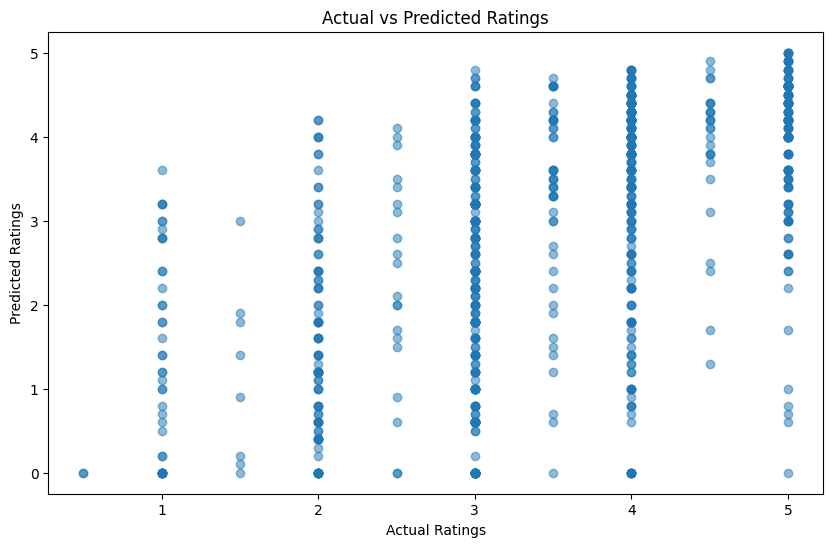

In [19]:
# Plotting the Actual vs Predicted Ratings
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.show()

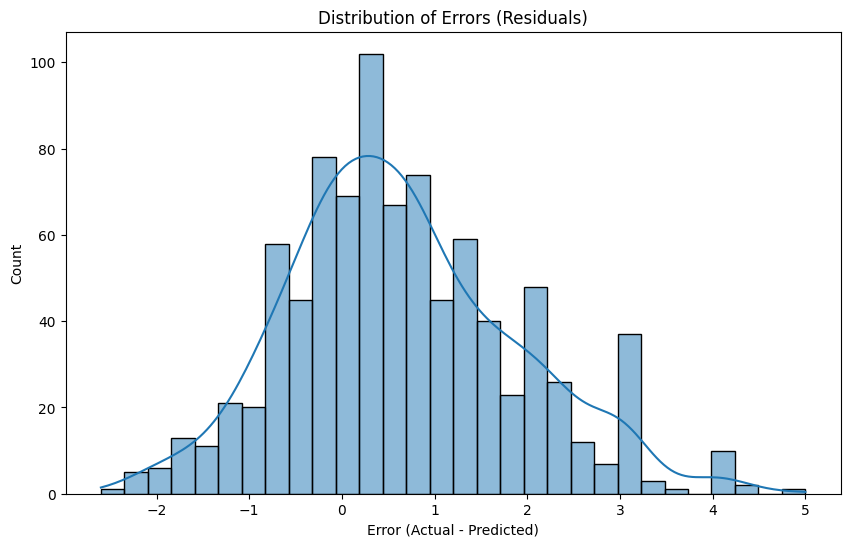

In [20]:
errors = np.array(actual) - np.array(predictions)
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Count')
plt.title('Distribution of Errors (Residuals)')
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import Binarizer

In [22]:
threshold = 4.0  # Relevant if rating >= threshold
k = 5 

In [23]:
binarizer = Binarizer(threshold=threshold)

In [24]:
actual_binary = binarizer.fit_transform(np.array(actual).reshape(-1, 1)).ravel()
predictions_binary = binarizer.transform(np.array(predictions).reshape(-1, 1)).ravel()


In [25]:
accuracy = accuracy_score(actual_binary, predictions_binary)
print("\nAccuracy: {:.4f}".format(accuracy))


Accuracy: 0.7817


In [26]:
precision = precision_score(actual_binary, predictions_binary)
recall = recall_score(actual_binary, predictions_binary)
print("\nPrecision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))


Precision: 0.4545
Recall: 0.5780


In [27]:
fpr, tpr, _ = roc_curve(actual_binary, predictions)
roc_auc = auc(fpr, tpr)
print("Area Under the Curve (AUC): {:.4f}".format(roc_auc))

Area Under the Curve (AUC): 0.8005


In [28]:
plt.figure(figsize=(15, 6))

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

Text(0.5, 1.0, 'Precision and Recall')

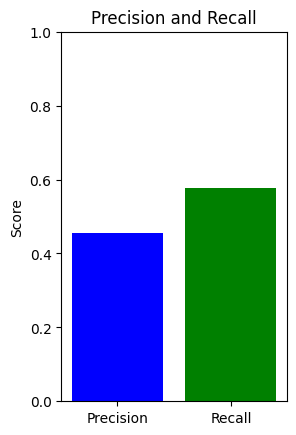

In [29]:
# Plotting Precision and Recall
plt.subplot(1, 2, 1)
plt.bar(['Precision', 'Recall'], [precision, recall], color=['blue', 'green'])
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Precision and Recall')

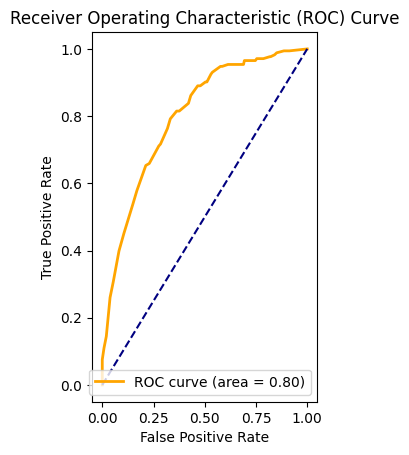

In [30]:
# Plotting ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

In [31]:
plt.tight_layout()
plt.show()

# Additional Metrics: Precision@k and Recall@k
precision_at_k = []
recall_at_k = []

<Figure size 640x480 with 0 Axes>

In [32]:
for user in test_users:
    user_pos_index = user_movie_table.index.get_loc(user)
    user_ratings = user_movie_table.loc[user]
    non_zero_ratings = user_ratings[user_ratings > 0].index

    actual_relevant_movies = user_ratings[non_zero_ratings]
    actual_relevant_movies = actual_relevant_movies[actual_relevant_movies >= threshold]

    # Get neighbors and their ratings
    distances, indices = model_knn.kneighbors(user_movie_table_matrix[user_pos_index, :].reshape(1, -1), n_neighbors=k+1)
    neighbors_indices = indices.flatten()[1:]  # skip the user itself

    predicted_relevant_movies = []

    for neighbor_index in neighbors_indices:
        neighbor_ratings = user_movie_table.iloc[neighbor_index]
        predicted_relevant_movies.extend(neighbor_ratings[neighbor_ratings >= threshold].index)

    # Calculate precision and recall for the top k recommendations
    predicted_relevant_movies = predicted_relevant_movies[:k]
    relevant_and_recommended = set(actual_relevant_movies.index) & set(predicted_relevant_movies)
    
    if len(predicted_relevant_movies) > 0:
        precision_at_k.append(len(relevant_and_recommended) / len(predicted_relevant_movies))
    else:
        precision_at_k.append(0)

    if len(actual_relevant_movies) > 0:
        recall_at_k.append(len(relevant_and_recommended) / len(actual_relevant_movies))
    else:
        recall_at_k.append(0)

In [35]:
# Calculate the average Precision@k and Recall@k
avg_precision_at_k = np.mean(precision_at_k)
avg_recall_at_k = np.mean(recall_at_k)
print("\nAverage Precision@{}: {:.4f}".format(k, avg_precision_at_k))
print("Average Recall@{}: {:.4f}".format(k, avg_recall_at_k))


Average Precision@5: 0.4272
Average Recall@5: 0.6808


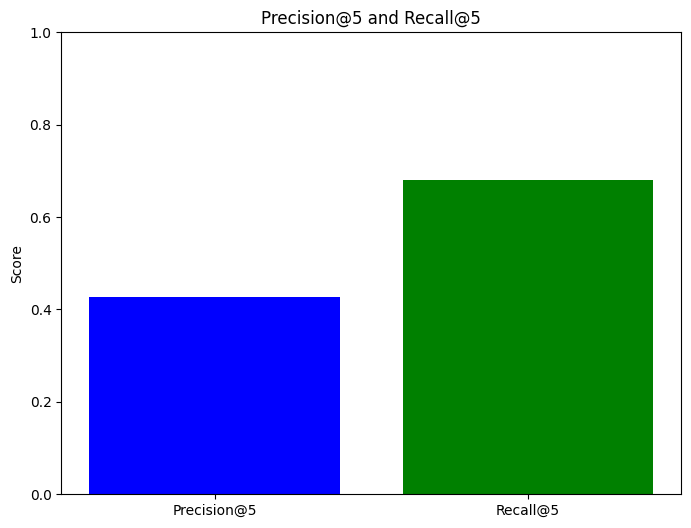

In [36]:
# Visualize Precision@k and Recall@k
plt.figure(figsize=(8, 6))
plt.bar(['Precision@{}'.format(k), 'Recall@{}'.format(k)], [avg_precision_at_k, avg_recall_at_k], color=['blue', 'green'])
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Precision@{} and Recall@{}'.format(k, k))
plt.show()